### Introduction

The Dataset used in this analysis contains over 2000 articles from BBC News that are classified into 4 categories which are tech, business, sport, politics and entertaiment. The data can be found at https://www.kaggle.com/yufengdev/bbc-text-categorization/data. The aim of the analysis is to predict whether an article is in the sport category or not using NLP techniques.

The google news Word2Vec pretrained vectors will be used to carry out this analysis. A random forest model, XGBoost model and a neural network using LSTM will all be created using the google news vectors as inputs to the models.

### Import Modules

In [39]:
import pandas as pd
import matplotlib as plt
import os
import numpy as np

import spacy
import nltk
import re
import gensim
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from gensim.models import LdaModel
from gensim.models.tfidfmodel import TfidfModel
from collections import Counter
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
import pyLDAvis.gensim
import langdetect
from tqdm import tqdm_notebook as tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score

pyLDAvis.enable_notebook()
stopwords = set(stopwords.words('english'))
stopwords.add('pron')
stopwords.add('PRON')
stopwords.add('-PRON-')
stopwords.add('-pron-')
[stopwords.add(x) for x in ['hi', 'thanks', 'thank', 'u', 'please', 'regard', 'regards', 'hello', 'dear']]
punctuation = set(string.punctuation)
lemmatize = WordNetLemmatizer()

from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Activation, Flatten, LSTM, Dropout, Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aislingtowey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aislingtowey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Read in Dataset & Basic Data Exploration

In [3]:
os.chdir('/Users/aislingtowey/Documents/Project/data')

#read in the data
bbc = pd.read_csv('bbc-text.csv')

#basic exploration
print(bbc.info())
print(bbc.head())
print(bbc['category'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
category    2225 non-null object
text        2225 non-null object
dtypes: object(2)
memory usage: 34.8+ KB
None
        category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve...
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64


### Data Preprocessing

In [4]:
#create a new column with binary values for cancellation sport
bbc['category_sport'] = 0
bbc.loc[bbc['category'] == 'sport', 'category_sport'] = 1
print(bbc['category_sport'].value_counts())

0    1714
1     511
Name: category_sport, dtype: int64


In [5]:
#function for cleaning and preprocessing the data
def cleaning(text):
    one = " ".join([i for i in text.lower().split() if i not in stopwords])
    two = "".join(i for i in one if i not in punctuation)
    two = " ".join([i for i in two.lower().split() if i not in stopwords])
    three = " ".join(lemmatize.lemmatize(i) for i in two.split())
    four = "".join([i for i in three if not i.isdigit()])
    return four

#clean the articles and create vectors from them
bbc['text_clean'] = [cleaning(x) for x in tqdm(bbc['text'])]

#change articles to a list
articles = bbc['text_clean'].to_list()
print(articles[1:2])
print(bbc.head())


['worldcom bos left book alone former worldcom bos bernie ebbers accused overseeing bn £bn fraud never made accounting decision witness told juror david myers made comment questioning defence lawyer arguing mr ebbers responsible worldcom problem phone company collapsed  prosecutor claim loss hidden protect firm share mr myers already pleaded guilty fraud assisting prosecutor monday defence lawyer reid weingarten tried distance client allegation cross examination asked mr myers ever knew mr ebbers make accounting decision aware mr myers replied ever know mr ebbers make accounting entry worldcom book mr weingarten pressed replied witness mr myers admitted ordered false accounting entry request former worldcom chief financial officer scott sullivan defence lawyer trying paint mr sullivan admitted fraud testify later trial mastermind behind worldcom accounting house card mr ebbers team meanwhile looking portray affable bos admission pe graduate economist whatever ability mr ebbers transfo

### Pretrained Google News Word2Vec Model

In [9]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

#load vectors from file
google_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
print(google_model)

#explore vectors
#print(model.wv.vocab)
#print(model.wv['suitcase'])
print(google_model.wv.most_similar('cost'))
print(google_model.wv.similarity('cost', 'fee'))
print(google_model.wv.doesnt_match("cost charge horse price".split()))

/Users/aislingtowey/.virtualenvs/topic_classifier/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[('costs', 0.7686900496482849), ('costing', 0.6449304819107056), ('price_tag', 0.5991894006729126), ('Costs', 0.5513685345649719), ('thecost', 0.544492244720459), ('pricetag', 0.5438615083694458), ('costof', 0.5437614917755127), ('Cost', 0.5356055498123169), ('price', 0.5076345801353455), ('savings', 0.5053994655609131)]
0.5038674887031331
horse


/Users/aislingtowey/.virtualenvs/topic_classifier/lib/python3.7/site-packages/gensim/models/keyedvectors.py:730: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


### Random Forest and XGBoost Vector Preparation

In [10]:
#now need to create an average word vector to represent each article 
#in order to run random forest and xgboost
#first create function to get the mean vector 
def article_vector(word2vec_model, article):
    # remove out-of-vocabulary words
    article = [word for word in article if word in google_model.wv.vocab]
    return np.mean(google_model[article], axis=0)

#then iterate through all articles and use the function
x = []
for article in articles: # append the vector for each article
    x.append(article_vector(google_model, article))
    
X = np.array(x) # list to array

### Random Forest

In [47]:
#random forest model
rf= RandomForestClassifier(random_state = 11)

#create grid search to try different combinations of hyperparameters
grid_param = { 
    'n_estimators': [30, 80, 120],
    'criterion': ['gini']
}

gs_rf = GridSearchCV(estimator=rf,  
                     param_grid=grid_param,
                     scoring='f1_macro',
                     cv=3)

#split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, bbc['category_sport'], random_state=11, test_size=0.3)

#balances the training data
sm = SMOTE(random_state=11, sampling_strategy='auto')
X_res, y_res = sm.fit_resample(X_train, y_train)

#train the model
gs_rf.fit(X_res, y_res)

#predict on the test set
rf_predict = gs_rf.predict(X_test)

#check metrics
print(classification_report(y_test, rf_predict, digits=3))
print(confusion_matrix(y_test, rf_predict))
print(f"ROC score = {roc_auc_score(y_test, rf_predict)}")
print(f"Best Parameters = {gs_rf.best_params_}")
print(f"Best F1 Score = {gs_rf.best_score_}") 

              precision    recall  f1-score   support

           0      0.853     0.938     0.894       533
           1      0.598     0.363     0.452       135

    accuracy                          0.822       668
   macro avg      0.725     0.651     0.673       668
weighted avg      0.802     0.822     0.804       668

[[500  33]
 [ 86  49]]
ROC score = 0.6505246334514627
Best Parameters = {'criterion': 'gini', 'n_estimators': 120}
Best F1 Score = 0.8869961104318782


### XGBoost

In [48]:
#xgboost model
xgb=XGBClassifier()

#A parameter grid for XGBoost
grid_param = {
        'learning_rate': [0.1, 0.15],
        'min_child_weight': [1, 2],
        'gamma': [1],
        'colsample_bytree': [0.8],
        'max_depth': [6, 7]
        }

gs_xgb = GridSearchCV(estimator=xgb,  
                     param_grid=grid_param,
                     scoring='f1_macro',
                     cv=3)

#split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, bbc['category_sport'], random_state=11, test_size=0.3)
sm = SMOTE(random_state=11, sampling_strategy='auto')
X_res, y_res = sm.fit_resample(X_train, y_train)

#train the model
gs_xgb.fit(X_res, y_res)

#predict on the test set
xgb_predict = gs_xgb.predict(X_test)

#check metrics
print(classification_report(y_test, xgb_predict, digits=3))
print(confusion_matrix(y_test, xgb_predict))
print(f"ROC score = {roc_auc_score(y_test, xgb_predict)}")
print(f"Best Parameters = {gs_xgb.best_params_}")
print(f"Best F1 Score = {gs_xgb.best_score_}") 

              precision    recall  f1-score   support

           0      0.871     0.863     0.867       533
           1      0.479     0.496     0.487       135

    accuracy                          0.789       668
   macro avg      0.675     0.680     0.677       668
weighted avg      0.792     0.789     0.790       668

[[460  73]
 [ 68  67]]
ROC score = 0.6796678479605309
Best Parameters = {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 2}
Best F1 Score = 0.8678815435250514


### Neural Network Preparation

In [29]:
#function to plot training v testing on accuracy and loss
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [36]:
#prep section for embedding layer of neural network

#first tokenize the data into a format that can be used by the word embeddings
#vectorize words in emails into a list of integers
#num_words sets the size of the vocab so only the 5000 words that are most common in the emails are kept
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(articles)

#create indexes for a text sequence ie. the indexes for all words in an article
X = tokenizer.texts_to_sequences(articles)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

#see the word indexes for one article
print(articles[2])
print(X[2])

#check the index of different words
#the indexing is ordered after the most common words in the text 
for word in ['news', 'hour', 'change', 'car']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))
    
#pad the sequence of words adding 0's so all text sequences are the same length
maxlen = 200
X = pad_sequences(X, padding='post', maxlen=maxlen)
print(X[2, :])

#split the data into training and test set using tokenized/ indexes text sequences
X_train, X_test, y_train, y_test = train_test_split(X, bbc['category_sport'], random_state=11, test_size=0.3)

tiger wary farrell gamble leicester say rushed making bid andy farrell great britain rugby league captain decide switch code anybody else involved process still way away going next stage tiger bos john well told bbc radio leicester moment still lot unknown andy farrell least medical situation whoever take going take big big gamble farrell persistent knee problem operation knee five week ago expected another three month leicester saracen believed head list rugby union club interested signing farrell decides move man game move across union well belief would better playing back least initially sure could make step league union involved centre said well think england would prefer progress position back row make use rugby league skill within forward jury whether cross divide club balance struck cost gamble option bringing readymade replacement
[2722, 6022, 3333, 5310, 1151, 15, 4516, 255, 374, 837, 3333, 169, 127, 429, 467, 854, 1190, 2109, 916, 2950, 1335, 607, 679, 72, 34, 242, 73, 43, 56

In [37]:
#Google News pretrained word2vec
#import warnings
#warnings.simplefilter("ignore", DeprecationWarning)
#load vectors from file
#googlenews_w2v = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#print(googlenews_w2v)

googlenews_w2v_size = 300
# Build embedding layers with weights initialized from each model
googlenews_w2v_matrix = np.zeros((len(tokenizer.word_index) + 1, googlenews_w2v_size))

for word,i in tokenizer.word_index.items():
  if word in google_model.vocab:
    googlenews_w2v_matrix[i] = google_model[word]
    
googlenews_w2v_emb = Embedding(len(tokenizer.word_index)+1,
                            googlenews_w2v_size,
                            weights=[googlenews_w2v_matrix],
                            input_length=maxlen)

### LSTM Neural Network

Train on 1089 samples, validate on 468 samples
Epoch 1/15
1089/1089 [==============================] - 28s 26ms/step - loss: 0.4389 - acc: 0.7888 - val_loss: 0.1408 - val_acc: 0.9829
Epoch 2/15
1089/1089 [==============================] - 25s 23ms/step - loss: 0.0933 - acc: 0.9853 - val_loss: 0.1728 - val_acc: 0.9594
Epoch 3/15
1089/1089 [==============================] - 25s 23ms/step - loss: 0.1525 - acc: 0.9642 - val_loss: 0.1690 - val_acc: 0.9573
Epoch 4/15
1089/1089 [==============================] - 25s 23ms/step - loss: 0.1564 - acc: 0.9624 - val_loss: 0.1677 - val_acc: 0.9573
Epoch 5/15
1089/1089 [==============================] - 27s 25ms/step - loss: 0.1351 - acc: 0.9669 - val_loss: 0.1518 - val_acc: 0.9594
Epoch 6/15
1089/1089 [==============================] - 25s 23ms/step - loss: 0.1362 - acc: 0.9651 - val_loss: 0.1853 - val_acc: 0.9509
Epoch 7/15
1089/1089 [==============================] - 25s 23ms/step - loss: 0.1549 - acc: 0.9624 - val_loss: 0.1813 - val_acc: 0.9509
E

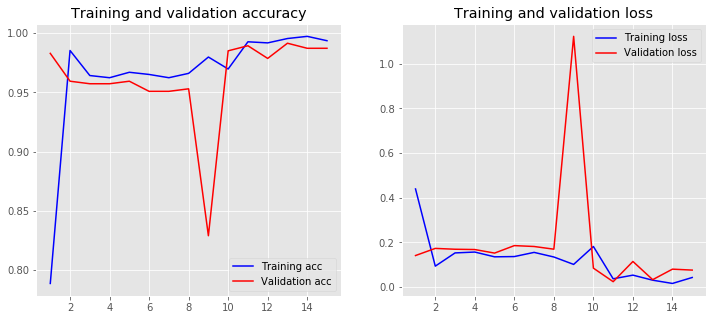

In [40]:
#LSTM model
np.random.seed(11)

#create architecture and compile
model = Sequential()
model.add(googlenews_w2v_emb)
model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))
model.add(LSTM(units=50)) 
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#fit the model
history = model.fit(X_train, y_train,
                    epochs=15,
                    verbose=True,
                    validation_split=0.3,
                    batch_size=32)

#check accuracy and loss
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Loss: {:.4f}".format(loss))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Loss:  {:.4f}".format(loss))

#create the accuracy and loss plots as defined in function
plot_history(history)

# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)

# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average = 'macro')
print('Testing Macro Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average = 'macro')
print('Testing Macro Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes, average = 'macro')
print('Testing Macro F1 score: %f' % f1)

# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

print(classification_report(y_test, yhat_classes, digits=2))

### Investigation of Models

In [49]:
#investigate some of the mistakes the models made
#first use the models to predict all of the data
bbc['rf_sport_pred'] = gs_rf.predict(X)
bbc['xgb_sport_pred'] = gs_xgb.predict(X)

#now check where the models made mistakes to see if any observations can be made
#pd.set_option('display.max_colwidth', -1)
bbc[(bbc['category_sport'] == 1) & (bbc['rf_sport_pred'] == 0)].iloc[1:5, [0,3,2,4,5]]
bbc[(bbc['category_sport'] == 1) & (bbc['xgb_sport_pred'] == 0)].iloc[1:5, [0,3,2,4,5]]

,category,text_clean,category_sport,rf_sport_pred,xgb_sport_pred
41,sport,federer claim dubai crown world number one rog...,1,0,0
77,sport,hodgson relish european clash former blackburn...,1,0,0
93,sport,south africa sweep top award south africa scha...,1,0,0
171,sport,red sink man magpie titus bramble goal put liv...,1,0,0


### Conclusion

The neural network model using LSTM achieves the best results in this analysis. The model achieves an accuracy score of 0.99 and an F1 score of 0.88 which indicates a very good model. 

More combinations of hyperperamaters could be tested on a server or with more computing power. The number of epochs in the neural network model could also be increased to see if performance improves.